In [48]:
import sys
import logging
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm
from google.cloud import bigquery
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats

client = bigquery.Client()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

In [49]:
def batch_commits_for_commit_build_times(
    commits: pd.DataFrame,
    workflow_runs: pd.DataFrame,
    batch_max_wait_time: int,
    observations: List,
):
    """
    Given a DataFrame of commits, batch them into groups based on the time between commits
    """
    current_batch_workflows = defaultdict(list)
    current_batch_end_time = commits.iloc[0]["date"] + pd.Timedelta(
        minutes=batch_max_wait_time
    )
    curr_commit_batch = [commits.iloc[0]]
    curr_batch_build_time = 0

    for i in range(1, len(commits)):
        curr_commit = commits.iloc[i]

        if curr_commit["date"] > current_batch_end_time:
            for _, build_times in current_batch_workflows.items():
                curr_batch_build_time += np.mean(
                    build_times
                )  # Take the average of all builds for a certain workflow across the batch of commits

            current_batch_end_time = curr_commit["date"] + pd.Timedelta(
                minutes=batch_max_wait_time
            )

            for c in curr_commit_batch:
                observations.append({"commit": c["sha"], "build_minutes": curr_batch_build_time / len(curr_commit_batch), "delay": batch_max_wait_time})

            current_batch_workflows = defaultdict(list)
            curr_commit_batch = []
            curr_batch_build_time = 0

        curr_commit_batch.append(curr_commit)
        workflows_for_commit = workflow_runs.loc[
            workflow_runs["head_sha"] == curr_commit["sha"]
        ]
        for _, workflow in workflows_for_commit.iterrows():
            current_batch_workflows[workflow["workflow_id"]].append(
                workflow["build_minutes"]
            )

    # Process the last batch
    for _, build_times in current_batch_workflows.items():
        curr_batch_build_time += np.mean(
            build_times
        )  # Take the average of all builds for a certain workflow across the batch of commits

    for c in curr_commit_batch:
        observations.append({"commit": c["sha"], "build_minutes": curr_batch_build_time / len(curr_commit_batch), "delay": batch_max_wait_time})

In [50]:
def process_control(commits_df: pd.DataFrame, workflow_runs: pd.DataFrame):
    control_data = {commits_df["sha"]: 0 for _, commits_df in commits_df.iterrows()}
    for _, workflow in workflow_runs.iterrows():
        control_data[workflow["head_sha"]] += workflow["build_minutes"]
    control_df = pd.DataFrame(list(control_data.items()), columns=["commit", "build_minutes"])
    control_df["delay"] = 0
    return control_df

In [51]:
def run_monte_carlo_simulation(
    all_commits: pd.DataFrame, workflow_runs: pd.DataFrame, iterations: int = 10
):
    observations = []
    for _ in tqdm(range(iterations)):
        bootstrap_sample = all_commits.sample(
            n=1000, replace=True
        ).sort_index()  # retain original sorted order which which started at the earliest commit in range and is ascending by time

        merge_queue_batch_delay = np.random.randint(1, 61)
        batch_commits_for_commit_build_times(
            bootstrap_sample, workflow_runs, merge_queue_batch_delay, observations
        )
    return pd.DataFrame(observations)

In [52]:
query_for_commit_shas = "SELECT sha, commit.committer.date FROM `scientific-glow-417622.beam.commits` ORDER BY commit.committer.date ASC"
query_for_workflow_runs = """
    SELECT
        workflow_run.head_sha,
        workflow_run.name,
        workflow_run.workflow_id,
        workflow_run.run_started_at,
        workflow_run.created_at,
        workflow_run.updated_at,
        TIMESTAMP_DIFF(workflow_run.updated_at, workflow_run.created_at, SECOND) / 60.0 AS build_minutes
    FROM
        `scientific-glow-417622.beam.commits` AS commits
    CROSS JOIN
        `scientific-glow-417622.beam.push_and_schedule_workflows`,
        UNNEST(workflow_runs) AS workflow_run
    WHERE
        commits.sha = workflow_run.head_sha AND workflow_run.event = 'push'
        """
logger.info("Fetching data from BigQuery...")
commits_df = client.query_and_wait(query_for_commit_shas).to_dataframe()
workflow_runs_df = client.query_and_wait(query_for_workflow_runs).to_dataframe()

INFO:__main__:Fetching data from BigQuery...


In [53]:
logger.info("Calculating control Build minutes...")
control_df = process_control(commits_df, workflow_runs_df)
logger.info("Running Monte Carlo Simulation...")
observations_df = run_monte_carlo_simulation(
    commits_df, workflow_runs_df, iterations=100
)

INFO:__main__:Calculating control Build minutes...


INFO:__main__:Running Monte Carlo Simulation...


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


In [54]:
observations_df

,commit,build_minutes,delay
0,b5794fc27b89dd8c550fdac7879e798f155520ad,75.305556,13
1,b5794fc27b89dd8c550fdac7879e798f155520ad,75.305556,13
2,b5794fc27b89dd8c550fdac7879e798f155520ad,75.305556,13
3,472ed9f8d8645fea8aadace94ea561aa511b2d70,23.583333,13
4,472ed9f8d8645fea8aadace94ea561aa511b2d70,23.583333,13
...,...,...,...
99995,102e2886545936d9bf2caa3a7cc0a06b9ced7f40,134.452083,39
99996,1eb9ea28d91da78b54c49bef6fffca5bc5ef40c6,134.452083,39
99997,c00e347c731c5f37a0ec383879922f34b8256111,157.050000,39
99998,cccdb4cd30ffae857849f99040c0e55b93372594,171.000000,39


In [55]:
# Query for all rows matching commit in observations_df dataframe
filtered_df = observations_df[observations_df['commit'] == "7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219"]
filtered_df


,commit,build_minutes,delay
991,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,507.116667,13
1996,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,169.038889,10
1997,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,169.038889,10
1998,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,169.038889,10
2996,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,253.558333,27
...,...,...,...
94990,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,507.116667,23
96992,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,253.558333,47
96993,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,253.558333,47
97995,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,106.060667,57


In [56]:
control_df

,commit,build_minutes,delay
0,b5794fc27b89dd8c550fdac7879e798f155520ad,225.916667,0
1,a93fa513181456f499e6d467f40da67fc42eda59,132.400000,0
2,472ed9f8d8645fea8aadace94ea561aa511b2d70,61.766667,0
3,84e6ceb2f0c9906fc1d64f630a320ea7c2126e92,64.200000,0
4,2f8eebb7fa7a439eecba604eacaf3611ae6f5fb6,189.600000,0
...,...,...,...
995,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,507.116667,0
996,c00e347c731c5f37a0ec383879922f34b8256111,157.050000,0
997,71a6c029ec75c54153c6466f28d50a439bdc5ff4,197.416667,0
998,cccdb4cd30ffae857849f99040c0e55b93372594,342.000000,0


In [45]:
# Citation: Data Aggregation step was assisted by ChatGPT
aggregated_observations_df = observations_df.groupby("commit").agg(
    build_minutes_mean=("build_minutes", 'mean'),
    delay_mean=("delay", 'mean'),
    build_minutes_2_5_percentile=("build_minutes", lambda x: np.percentile(x, 2.5)),
    build_minutes_97_5_percentile=("build_minutes", lambda x: np.percentile(x, 97.5)),
    delay_2_5_percentile=("delay", lambda x: np.percentile(x, 2.5)),
    delay_97_5_percentile=("delay", lambda x: np.percentile(x, 97.5)),
).reset_index()
aggregated_observations_df

,commit,build_minutes_mean,delay_mean,build_minutes_2_5_percentile,build_minutes_97_5_percentile,delay_2_5_percentile,delay_97_5_percentile
0,00462b13cc1eb36302013dea18b701e9e70b9058,130.059379,31.579545,31.254505,262.075000,2.000,58.825
1,00526dd3fa2a8fa9168cdb7f94c86af519f5c678,140.943925,28.121495,45.700000,228.500000,2.000,58.350
2,00a55272eaac451c3f364c4071e4af1ab56b88bd,73.206538,26.607477,23.816667,174.690741,2.000,60.000
3,00d5863551cc3e1f517b65d2f66eabb4c26fad95,43.603003,29.352381,17.620833,76.958889,2.000,59.000
4,00f07864784dc71b131244533abce4aaad48b5fa,7.424914,28.185567,0.000000,70.783333,2.400,57.600
...,...,...,...,...,...,...,...
995,fe262b630b3fd51854e667aa61a3ad0155f81634,188.245021,25.783019,50.375000,335.912500,2.000,59.000
996,fedca3ce18ea21424bd2381c75231e7399a8a6c2,133.565782,29.138614,37.027778,222.166667,2.500,59.000
997,ff03c129e07b9353a2005c76d91bdd12e4636565,99.244676,29.630952,34.856667,174.283333,2.075,59.925
998,ff272db75e685024dcae4cf84f3a979568c8ea62,245.628139,31.009804,123.369717,564.916667,2.000,59.000


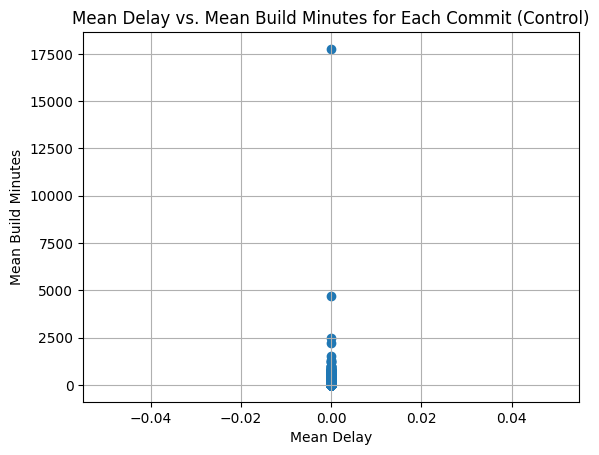

In [63]:
# Drop outlier
control_df = control_df[
    control_df["build_minutes"] < 3000
]

plt.scatter(control_df["delay"], control_df["build_minutes"],  label="Control")
plt.title("Mean Delay vs. Mean Build Minutes for Each Commit (Control)")
plt.xlabel("Mean Delay")
plt.ylabel("Mean Build Minutes")
plt.grid(True)
plt.show()

In [57]:
# Find outlier
aggregated_observations_df[aggregated_observations_df["build_minutes_mean"] > 8000]

,commit,build_minutes_mean,delay_mean,build_minutes_2_5_percentile,build_minutes_97_5_percentile,delay_2_5_percentile,delay_97_5_percentile
324,539f04233c6b181ad59e952befab792768f23d5e,10963.326087,30.452174,2959.583333,17757.5,2.85,60.0


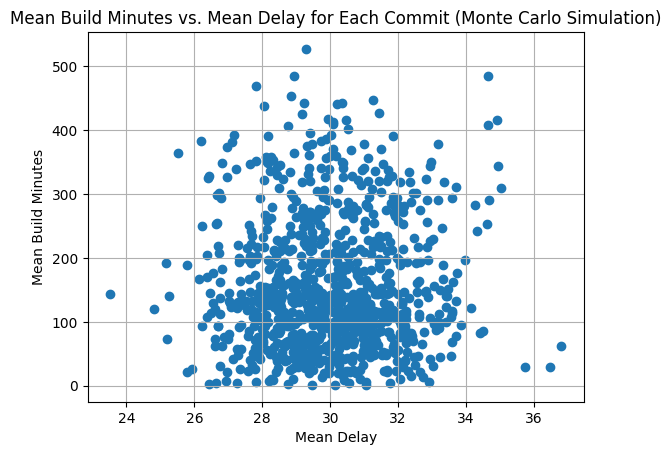

In [62]:
# Drop outliers (anything below 600 and anything equal to 0)
# Commits with build minutes equal to 0 likely made very minimal code changes or failed right before they began
# Commits with build minutes above 1000 are outliers because they likely represent commits that spent a very long time running or caused a hung CI job.
aggregated_observations_df = aggregated_observations_df[aggregated_observations_df["build_minutes_mean"] < 600]
aggregated_observations_df = aggregated_observations_df[aggregated_observations_df["build_minutes_mean"] > 0]

plt.scatter(aggregated_observations_df["delay_mean"], aggregated_observations_df["build_minutes_mean"])
plt.title('Mean Build Minutes vs. Mean Delay for Each Commit (Monte Carlo Simulation)')
plt.ylabel('Mean Build Minutes')
plt.xlabel('Mean Delay')
plt.grid(True)
plt.show()

#### Statistical test (Mann-Whitney-U / Wilcoxon) without error bars

In [66]:
control_build_minutes = control_df["build_minutes"]
print(control_build_minutes)
merge_queue_build_minutes = aggregated_observations_df["build_minutes_mean"]
print(merge_queue_build_minutes)

# We just want to know if the merge queue build minutes are greater than the control build minutes
u_statistic, p_value = stats.mannwhitneyu(merge_queue_build_minutes, control_build_minutes, alternative="less")
u_statistic, p_value

0      225.916667
1      132.400000
2       61.766667
3       64.200000
4      189.600000
          ...    
995    507.116667
996    157.050000
997    197.416667
998    342.000000
999    563.216667
Name: build_minutes, Length: 1000, dtype: float64
0      130.059379
1      140.943925
2       73.206538
3       43.603003
4        7.424914
          ...    
995    188.245021
996    133.565782
997     99.244676
998    245.628139
999    131.940458
Name: build_minutes_mean, Length: 944, dtype: float64


(332438.0, 7.738552618712188e-30)

# Overlay Control on Monte-Carlo Experiment

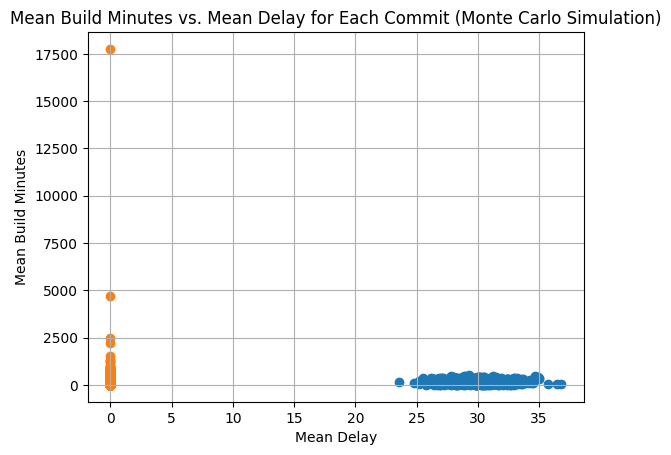

In [73]:

plt.scatter(aggregated_observations_df["delay_mean"], aggregated_observations_df["build_minutes_mean"], label="Merge Queue")
plt.scatter(control_df["delay"], control_df["build_minutes"], label="Control")
plt.title('Mean Build Minutes vs. Mean Delay for Each Commit (Monte Carlo Simulation)')
plt.ylabel('Mean Build Minutes')
plt.xlabel('Mean Delay')
plt.grid(True)
plt.show()

#### Error Bars attempt
- Could we try to calculate p-value from how close they are to the error bars?
- Previous statistical test just looks at mean, but there is sufficient variance

In [70]:
# Create error bars using 95% confidence interval
aggregated_observations_df['build_minutes_error'] = aggregated_observations_df.apply(lambda row: [
    row['build_minutes_mean'] - row['build_minutes_2_5_percentile'], 
    row['build_minutes_97_5_percentile'] - row['build_minutes_mean']
], axis=1)

aggregated_observations_df['delay_error'] = aggregated_observations_df.apply(lambda row: [
    row['delay_mean'] - row['delay_2_5_percentile'], 
    row['delay_97_5_percentile'] - row['delay_mean']
], axis=1)

# Filter out negative error bars because I was getting an error about this (LOOK BACK AND SEE WHY THIS IS HAPPENING)
# aggregated_observations_df = aggregated_observations_df[
#     (aggregated_observations_df['build_minutes_error'].apply(lambda x: x[0] >= 0 and x[1] >= 0)) &
#     (aggregated_observations_df['delay_error'].apply(lambda x: x[0] >= 0 and x[1] >= 0))
# ]

[[ 98.80487416  95.24392523  49.38987106 ...  64.38800926 122.25842193
   69.61730942]
 [132.01562063  87.55607477 101.48420301 ...  75.03865741 319.2885281
   72.7262091 ]]


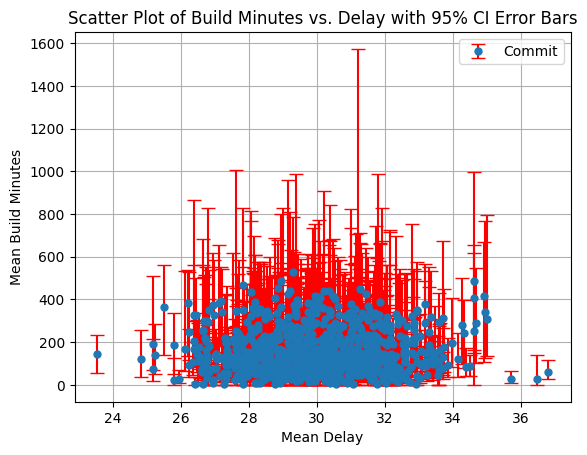

In [72]:
build_minutes_errors = np.array(aggregated_observations_df['build_minutes_error'].tolist()).T  # Transposing to get correct shape
delay_errors = np.array(aggregated_observations_df['delay_error'].tolist()).T  # Transposing to get correct shape
print(build_minutes_errors)

plt.errorbar(
    x=aggregated_observations_df['delay_mean'],
    y=aggregated_observations_df['build_minutes_mean'],
    # yerr=delay_errors,  # Error bars for delay
    yerr=build_minutes_errors,  # Error bars for build minutes
    fmt='o', ecolor='r', capsize=5, linestyle='None', markersize=5,
    label='Commit'
)

plt.xlabel('Mean Delay')
plt.ylabel('Mean Build Minutes')
plt.title('Scatter Plot of Build Minutes vs. Delay with 95% CI Error Bars')
plt.grid(True)
plt.legend()
plt.show()